In [1]:
import msprime, pyslim
import tskit
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import itertools
import math

import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
import gpustat
import pandas as pd
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch import nn
from torchvision.io import read_image
import torchvision.transforms as transforms

import sklearn
import sklearn.model_selection

rng = np.random.default_rng()

In [2]:
stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = min(zip(ids, ratios), key=lambda x: x[1])[0]
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)
print(stats)

GPUStatCollection(host=poppy, [
  [0] NVIDIA A100 80GB PCIe | 34°C,   0 % |  8709 / 81920 MB | gpatters(8706M)
  [1] NVIDIA A100 80GB PCIe | 28°C,   0 % |     0 / 81920 MB |
  [2] NVIDIA A100 80GB PCIe | 29°C,   0 % |     0 / 81920 MB |
])


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
base_folder = "bearded_seals"
labels = pd.read_csv(base_folder + "/labels.csv")
labels

,R0,rep,bias,N_avg,n,npops,nsibs
0,8.52,1,1.0,3617.809524,2000,305,912.0
1,8.52,1,15.5,3617.809524,2050,410,1088.0
2,8.52,1,30.0,3617.809524,2050,407,1091.0
3,8.52,2,1.0,4436.904762,2000,240,732.0
4,8.52,2,15.5,4436.904762,2050,356,1001.0
...,...,...,...,...,...,...,...
7645,9.90,49,15.5,16909.571429,2050,92,251.0
7646,9.90,49,30.0,16909.571429,2050,72,282.0
7647,9.90,50,1.0,14557.857143,2000,82,223.0
7648,9.90,50,15.5,14557.857143,2050,81,271.0


bearded_seals/bearded_seal_images/spaghetti_pops_8.52_1_1.0_2000.png
bearded_seals/bearded_seal_images/spaghetti_sibs_8.52_1_1.0_2000.png
bearded_seals/bearded_seal_images/sampling_intensity_8.52_1_1.0_2000.png


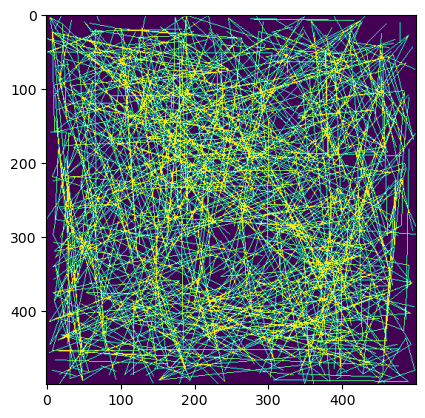

In [7]:
idx = 0
row = labels.iloc[idx,]
R0 = row.loc['R0']
rep = int(row.loc['rep'])
bias = row.loc['bias']
n = int(row.loc['n'])
pops_path = f'{base_folder}/bearded_seal_images/spaghetti_pops_{R0}_{rep}_{bias}_{n}.png'
print(pops_path)
pops = read_image(pops_path)
sibs_path = f'{base_folder}/bearded_seal_images/spaghetti_sibs_{R0}_{rep}_{bias}_{n}.png'
print(sibs_path)
sibs = read_image(sibs_path)
intensity_path = f'{base_folder}/bearded_seal_images/sampling_intensity_{R0}_{rep}_{bias}_{n}.png'
print(intensity_path)
intensity = read_image(intensity_path)
plt.imshow(sibs[0])

In [9]:
print(pops.size())
print(sibs.size())
print(intensity.size())
images = torch.cat((pops, sibs, intensity), 0)
print(images.size())

torch.Size([1, 500, 500])
torch.Size([1, 500, 500])
torch.Size([1, 500, 500])
torch.Size([3, 500, 500])


In [10]:
class KinDataset(Dataset):
    def __init__(self, base_folder, labels_file):
        self.labels = pd.read_csv(base_folder + "/" + labels_file)
        self.base_folder = base_folder
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        row = self.labels.iloc[idx,]
        R0 = row.loc['R0']
        rep = int(row.loc['rep'])
        bias = row.loc['bias']
        n = int(2000)
        spaghetti_pops_path = f'{self.base_folder}/bearded_seal_images/spaghetti_pops_{R0}_{rep}_{bias}_{n}.png'
        spaghetti_pops = read_image(spaghetti_pops_path)
        spaghetti_sibs_path = f'{self.base_folder}/bearded_seal_images/spaghetti_sibs_{R0}_{rep}_{bias}_{n}.png'
        spaghetti_sibs = read_image(spaghetti_sibs_path)
        intensity_path = f'{self.base_folder}/bearded_seal_images/sampling_intensity_{R0}_{rep}_{bias}_{n}.png'
        intensity = read_image(intensity_path)
        input_tensor = torch.cat((spaghetti_pops, spaghetti_sibs, intensity), 0).float()
        label = torch.tensor([self.labels['N_avg'].iloc[idx]]).float()
        return input_tensor, label
    
kin_dataset = KinDataset("bearded_seals", "labels.csv")

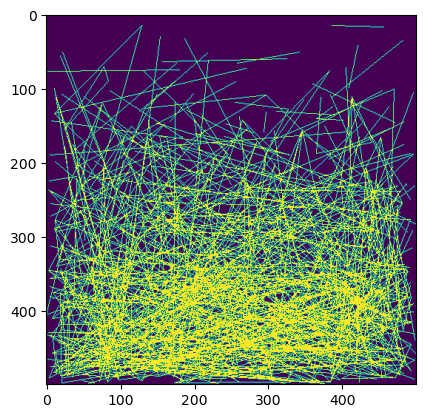

In [14]:
plt.imshow(kin_dataset[2][0][0])
plt.imshow(kin_dataset[2][0][1])
#plt.imshow(kin_dataset[2][0][2])

In [15]:
n_total = len(kin_dataset)
n_train = round(n_total*0.5)
n_valid = round((n_total-n_train)*0.5)
n_test = n_total-n_train-n_valid

In [16]:
train_kin, valid_kin, test_kin = random_split(kin_dataset, [n_train, n_valid, n_test], generator=torch.Generator().manual_seed(42))

batch_size = 64
train_kin_dl = DataLoader(train_kin, batch_size, shuffle = True)
valid_kin_dl = DataLoader(valid_kin, batch_size, shuffle = True)
test_kin_dl = DataLoader(test_kin, batch_size, shuffle = True)
print(len(train_kin))
print(len(valid_kin))
print(len(test_kin))

3825
1912
1913


In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=6, padding=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=6, padding=3)
        self.fc1 = nn.Linear(1000000, 1024)
        self.fc2 = nn.Linear(1024, 1)
        self.dropout = nn.Dropout(p=0.2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten() 
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = Net()
model = model.to(device) 

In [18]:
loss_fn = nn.MSELoss(reduction='mean')

In [20]:
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)

        loss_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} loss: {loss_hist_train[epoch]:.4f} val_loss: {loss_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid

In [21]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_kin_dl, valid_kin_dl)

Epoch 1 loss: 11427184.9089 val_loss: 1385280.7275
Epoch 2 loss: 1011235.3002 val_loss: 1020275.1491
Epoch 3 loss: 840452.5731 val_loss: 1193915.2913
Epoch 4 loss: 685757.9531 val_loss: 629502.5753
Epoch 5 loss: 467326.6138 val_loss: 621747.4643
Epoch 6 loss: 360591.9200 val_loss: 805462.1878
Epoch 7 loss: 316006.3004 val_loss: 545005.0547
Epoch 8 loss: 248127.8334 val_loss: 534626.9017
Epoch 9 loss: 244391.7437 val_loss: 526794.8094
Epoch 10 loss: 186341.9805 val_loss: 559587.1166
Epoch 11 loss: 185368.7719 val_loss: 591419.5578
Epoch 12 loss: 177570.6852 val_loss: 643890.2035
Epoch 13 loss: 198409.5902 val_loss: 594066.1935
Epoch 14 loss: 141277.6127 val_loss: 545682.1851
Epoch 15 loss: 178199.2734 val_loss: 543453.2466
Epoch 16 loss: 131588.0158 val_loss: 611809.5907
Epoch 17 loss: 226175.0098 val_loss: 551670.7053
Epoch 18 loss: 169924.6594 val_loss: 545422.0724
Epoch 19 loss: 130197.8710 val_loss: 553253.3724
Epoch 20 loss: 143537.6897 val_loss: 547109.9605


In [23]:
#Save model
PATH = "model_pops_sibs.pt"
torch.save(model.state_dict(), PATH)

In [16]:
# Load model
PATH = "model_pops_sibs.pt"
model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

Net(
  (conv1): Conv2d(2, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1000000, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

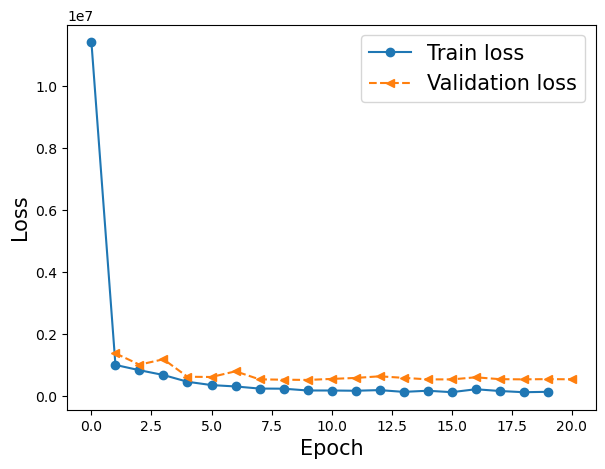

In [22]:
train_x = np.arange(len(hist[0]))
val_x = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_x, hist[0], '-o', label='Train loss')
ax.plot(val_x, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

plt.show()

## Record bias when testing
- Random simulations have maximum sampling intensity of 8
- Bias 15.5 have max intensity 132
- Bias 30 have max intensity 255

In [25]:
torch.cuda.synchronize()
model_cpu = model.cpu()

test_truth = np.empty(len(test_kin))
test_pred = np.empty(len(test_kin))
test_bias = np.empty(len(test_kin))

# If you add channels to the input, you need to change how the bias is calculated so that its using the correct image
with torch.no_grad():
    for i, (test_input, test_output) in enumerate(test_kin):
        test_pred[i] = model(test_input.unsqueeze(0))[0][0]
        test_truth[i] = test_output[0]
        test_bias[i] = torch.max(test_input[2]).item()/torch.min(test_input[2]).item()

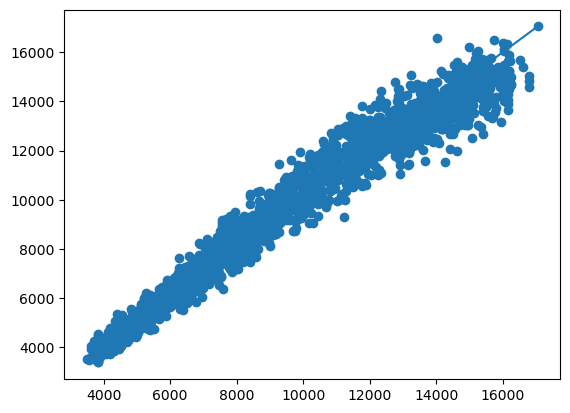

In [26]:
plt.scatter(test_truth, test_pred)
plt.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])

In [27]:
# Write test results to file
results = {'truth': test_truth, 'bearded_nn_pred': test_pred, 'bias': test_bias}
df = pd.DataFrame(data=results)
df.to_csv("bearded_seals_nn_results/model_pops_sibs.csv", index = False)

random reps 628
medium bias reps 628
high bias reps 628


Text(0.5, 1.0, 'High bias')

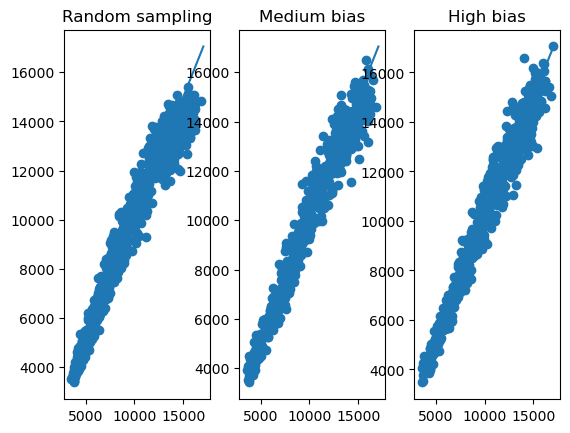

In [39]:
# Divide test data by sampling plan and plot separately
random = test_bias == 1
medium_bias = test_bias == 16.5
high_bias = test_bias == 31.875
print("random reps", sum(random))
print("medium bias reps", sum(random))
print("high bias reps", sum(random))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.scatter(test_truth[random], test_pred[random])
ax1.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])
ax1.set_title("Random sampling")
ax2.scatter(test_truth[medium_bias], test_pred[medium_bias])
ax2.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])
ax2.set_title("Medium bias")
ax3.scatter(test_truth[high_bias], test_pred[high_bias])
ax3.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])
ax3.set_title("High bias")
